In [1]:
from tdc.single_pred import ADME
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from noiseestimator import NoiseEstimator

In [2]:
# generate 1d array of 20 elements evenly spaced between 1 and 3
x_axis = np.logspace(0.7, 4, num=20, base=10).astype(int) # 5
noise_levels = np.linspace(0, 0.5, 20)
R = np.zeros([len(x_axis), len(noise_levels)])
R_std = np.zeros([len(x_axis), len(noise_levels)])
r2 = np.zeros([len(x_axis), len(noise_levels)])
r2_std = np.zeros([len(x_axis), len(noise_levels)])
R_real = np.zeros([len(x_axis), len(noise_levels)])
R_real_std = np.zeros([len(x_axis), len(noise_levels)])
r2_real = np.zeros([len(x_axis), len(noise_levels)])
r2_real_std = np.zeros([len(x_axis), len(noise_levels)])
class_r = np.zeros([len(x_axis), len(noise_levels)])
class_r_std = np.zeros([len(x_axis), len(noise_levels)])
class_roc_auc = np.zeros([len(x_axis), len(noise_levels)])
class_roc_auc_std = np.zeros([len(x_axis), len(noise_levels)])
for i, x in enumerate(x_axis):
    print(i, x)
    for j, noise in enumerate(noise_levels):
        dataset = pd.DataFrame(np.linspace(0, 1, x)).rename(columns={0: 'labels'})
        # max bound
        NE = NoiseEstimator(dataset.labels, noise, n_bootstrap=1000)
        noise_df = NE.noise_bootstraps
        R[i, j] = noise_df.pearsonr.mean()
        R_std[i, j] = noise_df.pearsonr.std()
        r2[i, j] = noise_df.r2.mean()
        r2_std[i, j] = noise_df.r2.std()
        # realistic bound
        NE = NoiseEstimator(dataset.labels, noise, noise, n_bootstrap=1000)
        noise_df = NE.noise_bootstraps
        R_real[i, j] = noise_df.pearsonr.mean()
        R_real_std[i, j] = noise_df.pearsonr.std()
        r2_real[i, j] = noise_df.r2.mean()
        r2_real_std[i, j] = noise_df.r2.std()
        # classification bound
        NE_class = NoiseEstimator(dataset.labels, noise, n_bootstrap=1000, classifier=True)
        noise_df_class = NE_class.noise_bootstraps
        class_r[i, j] = noise_df_class.matthews_corrcoef.mean()
        class_r_std[i, j] = noise_df_class.matthews_corrcoef.std()
        class_roc_auc[i, j] = noise_df_class.roc_auc.mean()
        class_roc_auc_std[i, j] = noise_df_class.roc_auc.std()

0 5
1 7
2 11
3 16
4 24
5 37
6 55
7 82
8 122
9 183
10 273
11 407
12 608
13 907
14 1353
15 2019
16 3012
17 4493
18 6703
19 10000


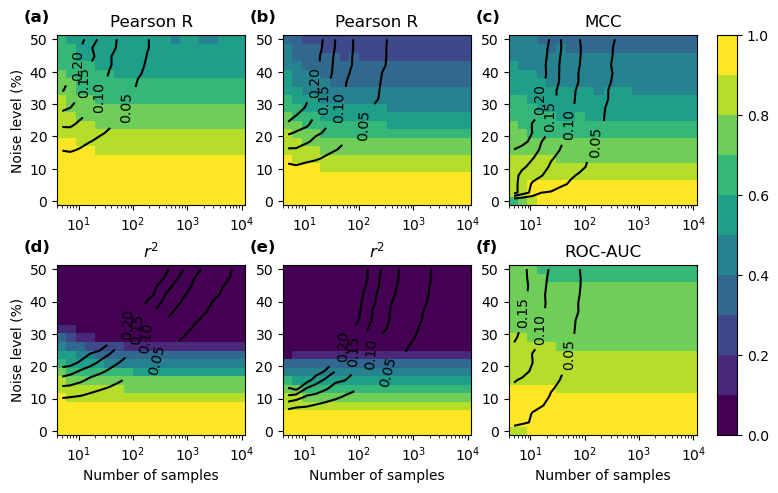

In [3]:
fig, axs = plt.subplots(2,3, figsize=(8,5))
cmap = plt.get_cmap('viridis', 10)
x = np.array(x_axis)
y = np.array(noise_levels) * 100

bottom, top = 0.1, 0.9
left, right = 0.1, 0.9
fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, hspace=0.35, wspace=0.2)
cbar_ax = fig.add_axes([0.925, bottom, 0.025, top-bottom])

# 1st column - max bounds regression 
axs[0,0].pcolor(x,y,R.T, vmin=0.0, vmax=1.0, cmap=cmap)
CS = axs[0,0].contour(x,y,R_std.T, colors='black', levels=[0.05,0.1,0.15,0.2])
axs[0,0].clabel(CS, inline=True, fontsize=10, )

# 2nd metric
axs[1,0].pcolor(x,y,r2.T, vmin=0.0, vmax=1.0, cmap=cmap)
CS = axs[1,0].contour(x,y,r2_std.T, colors='black', levels=[0.05,0.1,0.15,0.2])
axs[1,0].clabel(CS, inline=True, fontsize=10, )

# 2nd column - realistic bounds regression
axs[0,1].pcolor(x,y,R_real.T, vmin=0.0, vmax=1.0, cmap=cmap)
CS = axs[0,1].contour(x,y,R_real_std.T, colors='black', levels=[0.05,0.1,0.15,0.2])
axs[0,1].clabel(CS, inline=True, fontsize=10, )

# 2nd metric
axs[1,1].pcolor(x,y,r2_real.T, vmin=0.0, vmax=1.0, cmap=cmap)
CS = axs[1,1].contour(x,y,r2_real_std.T, colors='black', levels=[0.05,0.1,0.15,0.2])
axs[1,1].clabel(CS, inline=True, fontsize=10, )

# 3rd column - classification
img = axs[0,2].pcolor(x,y,class_r.T, vmin=0.0, vmax=1.0, cmap=cmap)
# add colorbar
cbar = plt.colorbar(img, ax=axs[0,2], cax=cbar_ax)  # label='MCC',
CS = axs[0,2].contour(x,y,class_r_std.T, colors='black', levels=[0.05,0.1,0.15,0.2])
axs[0,2].clabel(CS, inline=True, fontsize=10, )

# 2nd metric
axs[1,2].pcolor(x,y,class_roc_auc.T, vmin=0.0, vmax=1.0, cmap=cmap)
CS = axs[1,2].contour(x,y,class_roc_auc_std.T, colors='black', levels=[0.05,0.1,0.15,0.2])
axs[1,2].clabel(CS, inline=True, fontsize=10, )

for ax in axs.flat:
    ax.set_xscale('log')

axs[0,0].set_ylabel('Noise level (%)')
axs[1,0].set_ylabel('Noise level (%)')

axs[1,0].set_xlabel('Number of samples')
axs[1,1].set_xlabel('Number of samples')
axs[1,2].set_xlabel('Number of samples')

# add labels
axs[0,0].text(-0.175, 1.15, '(a)', transform=axs[0,0].transAxes, fontsize=12, fontweight='bold', va='top')
axs[0,1].text(-0.175, 1.15, '(b)', transform=axs[0,1].transAxes, fontsize=12, fontweight='bold', va='top')
axs[0,2].text(-0.175, 1.15, '(c)', transform=axs[0,2].transAxes, fontsize=12, fontweight='bold', va='top')
axs[1,0].text(-0.175, 1.15, '(d)', transform=axs[1,0].transAxes, fontsize=12, fontweight='bold', va='top')
axs[1,1].text(-0.175, 1.15, '(e)', transform=axs[1,1].transAxes, fontsize=12, fontweight='bold', va='top')
axs[1,2].text(-0.175, 1.15, '(f)', transform=axs[1,2].transAxes, fontsize=12, fontweight='bold', va='top')

# add metric as title
axs[0,0].set_title('Pearson R')
axs[0,1].set_title('Pearson R')
axs[0,2].set_title('MCC')
axs[1,0].set_title('$r^2$')
axs[1,1].set_title('$r^2$')
axs[1,2].set_title('ROC-AUC')

fig.savefig('../reports/pearson_r_synthetic_data.svg')